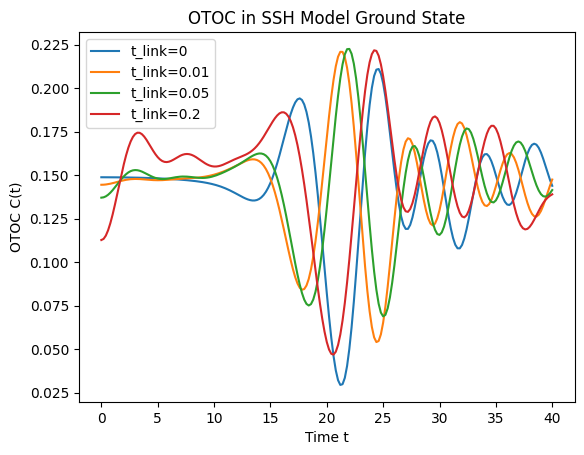

In [ ]:
import numpy as np

# ---------------------------------------------------------------------
# 1. SSH real-space single-particle Hamiltonian (your function)
# ---------------------------------------------------------------------

def build_real_space_H(L, v, w, t_link):
    """
    Build single-particle SSH Hamiltonian with alternating hoppings v, w
    and a weak link t_link between site 0 and site L-1.
    """
    H = np.zeros((L, L), dtype=complex)

    def add_hop(i, j, amp):
        H[i, j] -= amp
        H[j, i] -= np.conjugate(amp)

    # v and w terms along the chain
    for j in range(L - 1):
        if j % 2 == 0:
            add_hop(j, j + 1, v)
        else:
            add_hop(j, j + 1, w)

    # weak link between ends
    add_hop(0, L - 1, t_link)

    return H


# ---------------------------------------------------------------------
# 2. Ground-state correlation matrix C_ij = < c_i^\dagger c_j >
# ---------------------------------------------------------------------

def ground_state_correlation(H, filling=None):
    """
    Compute ground-state correlation matrix C for a quadratic Hamiltonian H.
    Assumes number conservation and uses a Slater determinant ground state.

    filling: number of occupied single-particle modes.
             If None, assumes half-filling (L/2).
    """
    L = H.shape[0]
    evals, evecs = np.linalg.eigh(H)

    if filling is None:
        filling = L // 2  # half-filling

    # Occupy the lowest 'filling' single-particle levels
    idx = np.argsort(evals)
    occ_idx = idx[:filling]

    Phi_occ = evecs[:, occ_idx]            # shape (L, filling)
    C0 = Phi_occ @ Phi_occ.conj().T        # C_ij = sum_alpha Phi_iα Phi*_jα

    return C0, evals, evecs


# ---------------------------------------------------------------------
# 3. Time evolution matrices and two-point correlators
# ---------------------------------------------------------------------

def single_particle_propagator(evals, evecs, t):
    """
    U(t) = e^{-i h t} given eigenvalues/vectors of h.
    """
    phases = np.exp(-1j * evals * t)
    U = evecs @ (phases[:, None] * evecs.conj().T)
    return U


def build_two_point_matrices(C0, evals, evecs, t):
    """
    Build the four basic two-point matrices:
      Cd(t_a, t_b) = < c_i^\dagger(t_a) c_j(t_b) >
    for t_a,t_b in {0, t}.

    Returns:
      Cd  : dict mapping (ta, tb) -> matrix of <c^\dagger(ta) c(tb)>
    """
    U = single_particle_propagator(evals, evecs, t)

    Cd = {}
    Cd[(0, 0)] = C0                                # <c^\dagger(0) c(0)>
    Cd[(1, 1)] = U @ C0 @ U.conj().T               # <c^\dagger(t) c(t)>
    Cd[(0, 1)] = C0 @ U.conj().T                   # <c^\dagger(0) c(t)>
    Cd[(1, 0)] = U @ C0                            # <c^\dagger(t) c(0)>

    return Cd


def make_two_point_function(Cd):
    """
    Given Cd[(ta,tb)] = < c_i^\dagger(ta) c_j(tb) >, return a function
    two_point(opA, opB) = <A B> where A,B are 'c' or 'cdag' at times 0 or t.

    op = (kind, site, time_index)
        kind: 'c' or 'cdag'
        site: 0..L-1
        time_index: 0 for t=0, 1 for t=t
    """
    # Precompute Ca[(ta,tb)] = < c_i(ta) c_j^\dagger(tb) >
    # using <c_i(ta) c_j^\dagger(tb)> = δ_ij - <c_j^\dagger(tb) c_i(ta)>
    L = next(iter(Cd.values())).shape[0]
    I = np.eye(L, dtype=complex)

    Ca = {}
    for ta in (0, 1):
        for tb in (0, 1):
            # Cd[(tb, ta)]^T has entries [j, i] = <c_j^\dagger(tb) c_i(ta)>
            Ca[(ta, tb)] = I - Cd[(tb, ta)].T

    def two_point(opA, opB):
        kindA, i, ta = opA
        kindB, j, tb = opB

        if kindA == 'cdag' and kindB == 'c':
            return Cd[(ta, tb)][i, j]
        elif kindA == 'c' and kindB == 'cdag':
            return Ca[(ta, tb)][i, j]
        else:
            # <c c> or <c^\dagger c^\dagger> vanish in a number-conserving Gaussian state
            return 0.0 + 0.0j

    return two_point


# ---------------------------------------------------------------------
# 4. Wick theorem (recursive) for Gaussian states
# ---------------------------------------------------------------------

def wick_expectation(ops, two_point):
    """
    Compute <A1 A2 ... A_{2n}> for a Gaussian fermionic state using Wick's theorem.

    ops: list of operator descriptors: ('c' or 'cdag', site, time_index)
    two_point: function (opA, opB) -> <opA opB>

    Returns: complex number = expectation value
    """
    n = len(ops)
    if n == 0:
        return 1.0 + 0.0j
    if n % 2 == 1:
        return 0.0 + 0.0j

    total = 0.0 + 0.0j
    first = ops[0]

    for j in range(1, n):
        pair = (first, ops[j])
        contraction = two_point(*pair)
        if contraction == 0:
            continue

        # Remaining operators after removing indices 0 and j
        remaining = ops[1:j] + ops[j+1:]
        # Sign from moving ops[j] next to ops[0] across (j-1) fermionic operators
        sign = (-1) ** (j - 1)

        total += sign * contraction * wick_expectation(remaining, two_point)

    return total


# ---------------------------------------------------------------------
# 5. OTOC for n_0(0) and n_{L-1}(t) in the SSH ground state
# ---------------------------------------------------------------------

def otoc_ssh_ground_state(L=24, v=0.6, w=1.0, t_link=0.1, times=None):
    """
    Compute OTOC(t) = < n_0(0) n_{L-1}(t) n_0(0) n_{L-1}(t) >
    for the SSH chain ground state, at a list of times.

    Returns: times (np.array), F (np.array of complex OTOC values)
    """
    if times is None:
        times = np.linspace(0, 10.0, 201)

    H = build_real_space_H(L, v, w, t_link)
    C0, evals, evecs = ground_state_correlation(H)

    left_site = 0
    right_site = L - 1

    F_vals = []

    for t in times:
        # Build 2-point functions at this time t
        Cd = build_two_point_matrices(C0, evals, evecs, t)
        two_point = make_two_point_function(Cd)

        # n_0(0) = c_0^\dagger(0) c_0(0)
        # n_L(t) = c_L^\dagger(t) c_L(t), with time_index=1 for t
        n0_0 = [('cdag', left_site, 0), ('c', left_site, 0)]
        nL_t = [('cdag', right_site, 1), ('c', right_site, 1)]

        # OTOC = < n0(0) nL(t) n0(0) nL(t) >
        ops = n0_0 + nL_t + n0_0 + nL_t  # total 8 fermionic operators

        F_t = wick_expectation(ops, two_point)
        F_vals.append(F_t)

    return np.array(times), np.array(F_vals)


# ---------------------------------------------------------------------
# Example usage
# ---------------------------------------------------------------------
def plot_ssh_otoc(F, t_link):
    import matplotlib.pyplot as plt
    
    plt.plot(F[0], F[1], label=f"t_link={t_link}")
    plt.xlabel("Time t")
    plt.ylabel("OTOC C(t)")
    plt.title("OTOC in SSH Model Ground State")
    plt.legend()
    plt.grid()

if __name__ == "__main__":
    L, v, w = 24, 0.6, 1.0
    times = np.linspace(0, 40.0, 201)

    for t_link in [0, 0.01, 0.05, 0.2]:
        ts, F = otoc_ssh_ground_state(L, v, w, t_link, times)
        plot_ssh_otoc((ts, F), t_link)
